In [4]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/cifar10-python/cifar-10-python.tar.gz
/kaggle/input/cifar10-python/cifar-10-batches-py/data_batch_1
/kaggle/input/cifar10-python/cifar-10-batches-py/data_batch_2
/kaggle/input/cifar10-python/cifar-10-batches-py/batches.meta
/kaggle/input/cifar10-python/cifar-10-batches-py/test_batch
/kaggle/input/cifar10-python/cifar-10-batches-py/data_batch_3
/kaggle/input/cifar10-python/cifar-10-batches-py/data_batch_5
/kaggle/input/cifar10-python/cifar-10-batches-py/data_batch_4
/kaggle/input/cifar10-python/cifar-10-batches-py/readme.html


In [17]:
import torch.nn as nn
import torch 
import torch.nn.functional as F 
import seaborn as sns

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [20]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

In [6]:
from torch.utils.data import DataLoader, TensorDataset

def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict


train_batch = {}
test_batch = unpickle('/kaggle/input/cifar10-python/cifar-10-batches-py/test_batch')
for i in range(5):
    train_batch[f'batch_{i+1}'] = unpickle("/kaggle/input/cifar10-python/cifar-10-batches-py/data_batch_%d"%(i + 1))


def get_dataset(batch_dict,test_dict):


    training_image = torch.tensor(torch.cat((torch.tensor(batch_dict['batch_1'][b'data']),torch.tensor(batch_dict['batch_2'][b'data']),torch.tensor(batch_dict['batch_3'][b'data']),torch.tensor(batch_dict['batch_4'][b'data']),torch.tensor(batch_dict['batch_5'][b'data'])),0),dtype = torch.float32)
    training_labels = torch.tensor(torch.cat((torch.tensor(batch_dict['batch_1'][b'labels']),torch.tensor(batch_dict['batch_2'][b'labels']),torch.tensor(batch_dict['batch_3'][b'labels']),torch.tensor(batch_dict['batch_4'][b'labels']),torch.tensor(batch_dict['batch_5'][b'labels']))))     

    test_images = torch.tensor(test_dict[b'data'],dtype = torch.float32)
    test_labels = torch.tensor(test_dict[b'labels'])

    training_image = training_image.view(50000,3,32,32)
    test_images = test_images.view(test_images.shape[0],3,32,32)

    return training_image,training_labels,test_images,test_labels


def make_batches(batch_size=16):
    training_image,training_labels,test_images,test_labels = get_dataset(train_batch,test_batch)
    train_dataset = TensorDataset(training_image,training_labels)
    test_dataset = TensorDataset(test_images,test_labels)
    train_loader = DataLoader(train_dataset,shuffle=True,batch_size=batch_size)
    test_loader = DataLoader(test_dataset,shuffle =True,batch_size=batch_size)

    return train_loader,test_loader

In [36]:

def training(model,criterion,optimizer,train_loader,epochs=10,device='cuda'):
    training_losses = []
    running_loss = 0.0
    training_accuracy = 0
    for epoch in range(epochs):
        for i,(images,labels) in enumerate(train_loader):
            images= images.to(device)
            labels = labels.to(device)
            output = model(images)

            loss = criterion(output,labels)
            running_loss += loss.item()
            optimizer.zero_grad()

            loss.backward()

            optimizer.step()

            _, predicted = torch.max(output.data, 1)

            training_accuracy += (predicted == labels).sum().item()
            if ((i+1)%100 == 0):
                print(f'epoch:{epoch + 1},loss:{loss.item():.4f}')
                
        avg_train_loss = running_loss / len(train_loader)
        training_losses.append(avg_train_loss)
        
        print(f'accuracy:{training_accuracy*100/50000}')
        training_accuracy = 0    

#     torch.save(model.state_dict(),'/kaggle/working/model.pth')

    return training_losses




In [39]:
def evaluation(model,test_loader,device='cuda'):
    with torch.no_grad():
        all_predictions = []
        all_labels = []
        n_correct = 0
        n_samples = 0
        test_loss = 0.0
        test_accuracy = 0
        for i,(images, labels) in enumerate(test_loader):
            images= images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            n_samples += labels.size(0)
            n_correct += (predicted == labels).sum().item()
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            
        acc = 100.0 * n_correct / n_samples
        
        
        avg_test_loss = test_loss / len(test_loader.dataset)
        print(f'Accuracy of the network on the 10000 test images: {acc} %')
        
        return all_predictions,all_labels,avg_test_loss

In [25]:
def draw_matrix(all_predictions,all_labels):
    conf_matrix = confusion_matrix(all_labels, all_predictions)
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

In [8]:
class Resnet(nn.Module):

  def __init__ (self):

    super(Resnet,self).__init__()

    self.pad = nn.ZeroPad2d(2)

    self.Conv0 = nn.Conv2d(3,64,3,padding=1)
    self.Conv1 = nn.Conv2d(64,64,3,padding=1)
    self.Conv2 = nn.Conv2d(64,128,3,padding=1)
    self.Conv3 = nn.Conv2d(128,128,3,padding=1)
    self.Conv4 = nn.Conv2d(128,256,3,padding=1)
    self.Conv5 = nn.Conv2d(256,256,3,padding=1)
    self.Conv6 = nn.Conv2d(256,512,3,padding=1)
    self.Conv7 = nn.Conv2d(512,512,3,padding=1)
    self.maxpool = nn.MaxPool2d(2)

    self.bnorm1 = nn.BatchNorm2d(64)
    self.bnorm2 = nn.BatchNorm2d(128)
    self.bnorm3 = nn.BatchNorm2d(256)
    self.bnorm4 = nn.BatchNorm2d(512)

    self.avgpool = nn.AvgPool2d(2)

    self.Linear1 = nn.Linear(512*2*2,512)
    self.Linear2 = nn.Linear(512,10)

    self.softmax = nn.Softmax(1)


  def forward(self,x) :

     x = self.Conv0(x)

     shortcut = x

     x = F.relu(self.Conv1(x))
     x = F.relu(self.bnorm1(self.Conv1(x)))
     x = x + shortcut

     shortcut = x

     x = F.relu(self.Conv1(x))
     x = F.relu(self.bnorm1(self.Conv1(x)))
     x = x + shortcut

     shortcut = F.relu(self.bnorm2(self.Conv2(x)))
     shortcut = self.maxpool(shortcut)

     x = F.relu(self.bnorm2(self.Conv2(x)))
     x = F.relu(self.bnorm2(self.Conv3(x)))
     x = self.maxpool(x)
     x = x + shortcut

     shortcut = x

     x = F.relu(self.bnorm2(self.Conv3(x)))
     x = F.relu(self.bnorm2(self.Conv3(x)))
     x = x + shortcut

     shortcut = F.relu(self.bnorm3(self.Conv4(x)))
     shortcut = self.maxpool(shortcut)

     x = F.relu(self.bnorm3(self.Conv4(x)))
     x = F.relu(self.bnorm3(self.Conv5(x)))
     x = self.maxpool(x)
     x = x + shortcut

     shortcut = x

     x = F.relu(self.bnorm3(self.Conv5(x)))
     x = F.relu(self.bnorm3(self.Conv5(x)))
     x = x + shortcut

     shortcut = F.relu(self.bnorm4(self.Conv6(x)))
     shortcut = self.maxpool(shortcut)

     x = F.relu(self.bnorm4(self.Conv6(x)))
     x = F.relu(self.bnorm4(self.Conv7(x)))
     x = self.maxpool(x)
     x = x + shortcut

     shortcut = x

     x = F.relu(self.bnorm4(self.Conv7(x)))
     x = F.relu(self.bnorm4(self.Conv7(x)))
     x = x + shortcut


     x = self.avgpool(x)

     x = x.view(x.shape[0],512*2*2)
     x = F.relu(self.Linear1(x))

     x = self.Linear2(x)
    #  x = self.softmax(x)


     return x








In [31]:
resnet = Resnet()

In [32]:
device = 'cuda'
resnet.to(device)

Resnet(
  (pad): ZeroPad2d((2, 2, 2, 2))
  (Conv0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (Conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (Conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (Conv3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (Conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (Conv5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (Conv6): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (Conv7): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (bnorm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bnorm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bnorm3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine

In [33]:
train_loader,test_loader = make_batches(128)

/tmp/ipykernel_25/53764489.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  training_image = torch.tensor(torch.cat((torch.tensor(batch_dict['batch_1'][b'data']),torch.tensor(batch_dict['batch_2'][b'data']),torch.tensor(batch_dict['batch_3'][b'data']),torch.tensor(batch_dict['batch_4'][b'data']),torch.tensor(batch_dict['batch_5'][b'data'])),0),dtype = torch.float32)
/tmp/ipykernel_25/53764489.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  training_labels = torch.tensor(torch.cat((torch.tensor(batch_dict['batch_1'][b'labels']),torch.tensor(batch_dict['batch_2'][b'labels']),torch.tensor(batch_dict['batch_3'][b'labels']),torch.tensor(batch_dict['batch_4'][b'labels']),torch.tensor(

In [34]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(resnet.parameters(),lr = 0.001)

In [37]:
training_losses =  training(resnet,criterion,optimizer,train_loader,epochs = 15)

epoch:1,loss:1.1184
epoch:1,loss:1.1117
epoch:1,loss:0.8390
accuracy:62.468
epoch:2,loss:0.8110
epoch:2,loss:0.6813
epoch:2,loss:0.7894
accuracy:72.894
epoch:3,loss:0.6306
epoch:3,loss:0.8229
epoch:3,loss:0.4775
accuracy:78.84
epoch:4,loss:0.5017
epoch:4,loss:0.4618
epoch:4,loss:0.4807
accuracy:82.966
epoch:5,loss:0.4833
epoch:5,loss:0.4413
epoch:5,loss:0.3455
accuracy:85.848
epoch:6,loss:0.3039
epoch:6,loss:0.3274
epoch:6,loss:0.2997
accuracy:88.266
epoch:7,loss:0.2838
epoch:7,loss:0.1967
epoch:7,loss:0.2323
accuracy:90.19
epoch:8,loss:0.1553
epoch:8,loss:0.2830
epoch:8,loss:0.3597
accuracy:92.218
epoch:9,loss:0.1982
epoch:9,loss:0.2185
epoch:9,loss:0.3380
accuracy:93.516
epoch:10,loss:0.1013
epoch:10,loss:0.2070
epoch:10,loss:0.0963
accuracy:94.91
epoch:11,loss:0.0577
epoch:11,loss:0.1470
epoch:11,loss:0.0640
accuracy:95.618
epoch:12,loss:0.0705
epoch:12,loss:0.0815
epoch:12,loss:0.1507
accuracy:96.578
epoch:13,loss:0.0828
epoch:13,loss:0.1223
epoch:13,loss:0.0712
accuracy:97.122
epo

In [40]:
all_predictions,all_labels,test_loss = evaluation(resnet,test_loader)

Accuracy of the network on the 10000 test images: 86.07 %


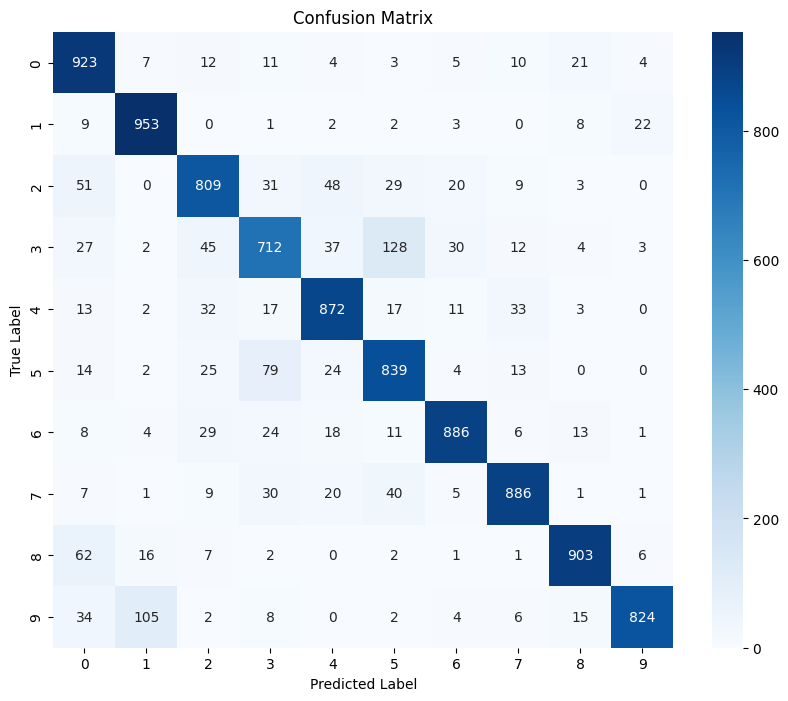

In [42]:
draw_matrix(all_predictions,all_labels)